In [40]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skl
import torch.linalg as lin

import sys; sys.path.append('..')

### 앞선 LQR의 결과물

In [41]:
def calculate_K(Q, q, state_dim, action_dim):
    K_t =  - torch.matmul(torch.linalg.inv(Q[:action_dim, :action_dim]), Q[state_dim:, :state_dim])
    k_t = - torch.matmul(torch.linalg.inv(Q[state_dim:,  state_dim:]), q[state_dim:, :])
    
    return K_t, k_t

In [42]:
def calculate_V(C, c, state_dim, action_dim, K_t, small_k):
    V_t = C[:state_dim, state_dim] + torch.matmul(C[:state_dim, state_dim:], K_t) + torch.matmul(K_t.T, C[state_dim:, :state_dim]) + torch.matmul(torch.matmul(K_t.T, C[state_dim:, state_dim:]), K_t)
    v_t = c[:state_dim, :] + torch.matmul(C[:state_dim, state_dim:], small_k) + torch.matmul(K_t.T, c[state_dim:, :]) + torch.matmul(torch.matmul(K_t.T, C[state_dim:, state_dim:]), small_k)
    
    return V_t, v_t

In [43]:
def calculate_Q(C, c, Large_V, small_v, F, f):
    Q_t = C + torch.matmul(torch.matmul(F.T, Large_V), F)
    q_t = c + torch.matmul(torch.matmul(F.T, Large_V), f) + torch.matmul(F.T, small_v)
    
    return Q_t, q_t

In [44]:
def backward_recursion(state_dim, action_dim, C, c, F, f, T):
    
    # dictionary of K
    Large_K = dict()
    small_k = dict()

    # dictionary of V
    Large_V = dict()
    small_v = dict()

    # dictionary of Q
    Large_Q = dict()
    small_q = dict()
    
    K_t, k_t = calculate_K(C, c, state_dim, action_dim)

    Large_K[T] = K_t
    small_k[T] = k_t

    V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
    Large_V[T] = V_t
    small_v[T] = v_t

    for time in range(T-1, 0, -1):

        # calculate Q
        Q_t, q_t = calculate_Q(C, c, V_t, v_t, F, f)
        Large_Q[time] = Q_t
        small_q[time] = q_t

        K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
        Large_K[time] = K_t
        small_k[time] = k_t

        V_t, v_t = calculate_V(C, c, state_dim, action_dim, K_t, k_t)
        Large_V[time] = V_t
        small_v[time] = v_t
        
    return (Large_Q, small_q), (Large_K, small_k), (Large_V, small_v)

In [45]:
def forward_recursion(x0, Large_K, small_k, F, f, T):
    x_dict = dict()
    u_dict = dict()
    
    x_dict[1] = x0

    for time in range(1, T):

        u_t = torch.matmul(Large_K[time], x_dict[time]) + small_k[time]
        u_dict[time] = u_t

        next_x = torch.matmul(F, torch.cat([x_dict[time], u_t], dim=0)) + f
        x_dict[time+1] = next_x
        
    return x_dict, u_dict

# iterative LQR

여태까지 했던 것처럼 모든 dynamic system이 linear system이라면 좋겠지만 대다수가 linear system이 아닙니다.
뿐만 아니라 Cost function이 Quadratic 구조가 아닌 경우도 있습니다.
그렇기에 non-linear system 모델을 바로 LQR에 사용할 수는 없습니다.
이러한 경우에는 iterative LQR(iLQR)을 적용해볼 수 있습니다.

iLQR의 주된 아이디어는

1. Linear가 아닌 dynamic system을 linear하게 근사합니다.
2. Quadratic이 아닌 Cost function을 Quadratic으로 근사합니다.

우선 근사해야할 non-linear 함수와, Cost function을 정해봅시다.

예제로 dynamic system는 MLP(Multi-Layer Perceptron)을,

Cost function은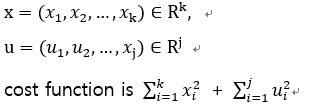

사용해볼 것입니다.

In [46]:
# initial setting
state_dim = 2
action_dim = 3
T = 20

In [47]:
import torch
import torch.nn as nn


class MLP(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list = [64, 32],
                 hidden_act: str = 'ReLU',
                 out_act: str = 'Identity'):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_act = getattr(nn, hidden_act)()
        self.out_act = getattr(nn, out_act)()

        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_act)
            else:
                self.layers.append(self.hidden_act)

    def forward(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs
    
def cost_func(x):
    return torch.sum(torch.pow(x, 2)) / 10

### get jacobian and hessian metrix
by torch.autograd.functional

In [48]:
dynamic_system = MLP(input_dim=5,
                     output_dim=2,
                     num_neurons=[16],
                     hidden_act='ReLU')

x = torch.randn(size=(1, 5))

with torch.no_grad():
    y = dynamic_system(x)
cost = cost_func(x)

In [49]:
torch.autograd.functional.jacobian(dynamic_system, inputs=x)

tensor([[[[ 0.1492,  0.0713,  0.0055, -0.1256, -0.0265]],

         [[ 0.0257,  0.1743,  0.2762,  0.1459,  0.2131]]]])

In [50]:
torch.autograd.functional.hessian(cost_func, inputs=x)

tensor([[[[0.2000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.2000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.2000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.2000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.2000]]]])

## Get Jacobian and hessian, approximate as a linear-quadratic system 

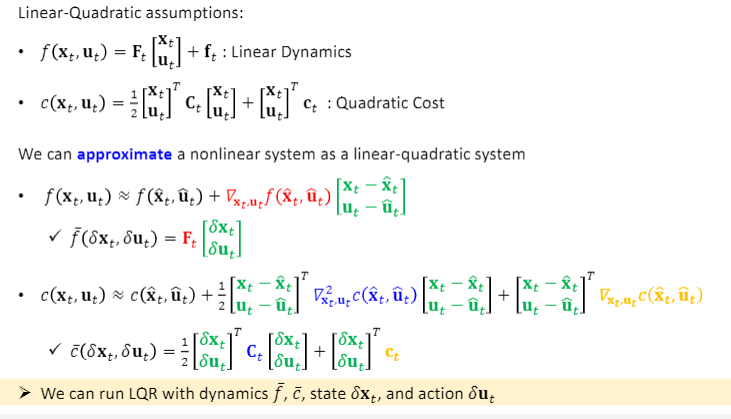

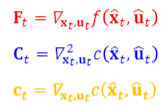

In [51]:
x_hat = torch.rand(size=(state_dim, T))
u_hat = torch.rand(size=(action_dim, T))

In [52]:
Fs = dict()
fs = dict()
Large_Cs = dict()
small_cs = dict()


for time in range(T):
    x_and_u = torch.cat([x_hat[:, time], u_hat[:, time]]).T
    time += 1

    Fs[time] = torch.autograd.functional.jacobian(dynamic_system, inputs=x_and_u)
    Large_Cs[time] = torch.autograd.functional.hessian(cost_func, inputs=x_and_u).T
    small_cs[time] = (torch.autograd.functional.jacobian(cost_func, inputs=x_and_u).T).unsqueeze(dim=1)
    fs[time] = torch.zeros(size=(state_dim, 1))

### 함수화

In [53]:
def linearization(x_hat, u_hat, dynamic_system, cost_func, state_dim, T):
    Fs = dict()
    fs = dict()
    Large_Cs = dict()
    small_cs = dict()

    for time in range(T):
        x_and_u = torch.cat([x_hat[:, time], u_hat[:, time]]).T
        time += 1

        Fs[time] = torch.autograd.functional.jacobian(dynamic_system, inputs=x_and_u)
        Large_Cs[time] = torch.autograd.functional.hessian(cost_func, inputs=x_and_u).T
        small_cs[time] = (torch.autograd.functional.jacobian(cost_func, inputs=x_and_u).T).unsqueeze(dim=1)
        fs[time] = torch.zeros(size=(state_dim, 1))
        
    return Fs, fs, Large_Cs, small_cs



기존 LQR에서와 달리 시간에 따라 C, F가 바뀌게 되므로 기존에 만든 함수에서도 약간의 변화가 필요합니다. 

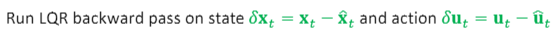

In [54]:
# dictionary of K
Large_K = dict()
small_k = dict()

# dictionary of V
Large_V = dict()
small_v = dict()

# dictionary of Q
Large_Q = dict()
small_q = dict()

K_t, k_t = calculate_K(Large_Cs[T], small_cs[T], state_dim, action_dim)

Large_K[T] = K_t
small_k[T] = k_t

V_t, v_t = calculate_V(Large_Cs[T], small_cs[T], state_dim, action_dim, K_t, k_t)
Large_V[T] = V_t
small_v[T] = v_t


for time in range(T-1, 0, -1):
    
    # calculate Q
    Q_t, q_t = calculate_Q(Large_Cs[time], small_cs[time], V_t, v_t, Fs[time], fs[time])
    Large_Q[time] = Q_t
    small_q[time] = q_t

    K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
    Large_K[time] = K_t
    small_k[time] = k_t

    V_t, v_t = calculate_V(Large_Cs[time], small_cs[time], state_dim, action_dim, K_t, k_t)
    Large_V[time] = V_t
    small_v[time] = v_t

### 함수화

In [55]:
def backward_recursion_ilqr(state_dim, action_dim, Large_Cs, small_cs, Fs, fs, T):
    Large_K = dict()
    small_k = dict()

    # dictionary of V
    Large_V = dict()
    small_v = dict()

    # dictionary of Q
    Large_Q = dict()
    small_q = dict()

    K_t, k_t = calculate_K(Large_Cs[T], small_cs[T], state_dim, action_dim)

    Large_K[T] = K_t
    small_k[T] = k_t

    V_t, v_t = calculate_V(Large_Cs[T], small_cs[T], state_dim, action_dim, K_t, k_t)
    Large_V[T] = V_t
    small_v[T] = v_t


    for time in range(T-1, 0, -1):

        # calculate Q
        Q_t, q_t = calculate_Q(Large_Cs[time], small_cs[time], V_t, v_t, Fs[time], fs[time])
        Large_Q[time] = Q_t
        small_q[time] = q_t

        K_t, k_t = calculate_K(Q_t, q_t, state_dim, action_dim)
        Large_K[time] = K_t
        small_k[time] = k_t

        V_t, v_t = calculate_V(Large_Cs[time], small_cs[time], state_dim, action_dim, K_t, k_t)
        Large_V[time] = V_t
        small_v[time] = v_t
        
    return Large_Q, small_q, Large_K, small_k, Large_V, small_v



In [56]:
Large_Q, small_q, Large_K, small_k, Large_V, small_v = backward_recursion_ilqr(state_dim, action_dim, Large_Cs, small_cs, Fs, fs, T)

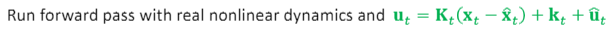

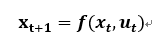

In [57]:
xs = x_hat[:, 0].unsqueeze(dim=1)
us = torch.zeros(size=(action_dim, 1))

for time in range(1, T):
    u_t = torch.matmul(Large_K[time], (xs[:, -1].unsqueeze(dim=1) - x_hat[:, time].unsqueeze(dim=1))) + small_k[time] + u_hat[:, time].unsqueeze(dim=1)

    us = torch.cat([us, u_t], dim=1)
    
    x_real = dynamic_system(torch.cat([xs[:, -1].unsqueeze(dim=1), u_t]).T).T
    xs = torch.cat([xs, x_real], dim=1)
    
us = us[1:]

### 함수화

In [58]:
def forward_recursion_ilqr(x_hat, u_hat, Large_K, small_k, dynamic_system, T):
    xs = x_hat[:, 0].unsqueeze(dim=1)
    us = torch.zeros(size=(action_dim, 1))

    for time in range(1, T):
        u_t = torch.matmul(Large_K[time], (xs[:, -1].unsqueeze(dim=1) - x_hat[:, time].unsqueeze(dim=1))) + small_k[time] + u_hat[:, time].unsqueeze(dim=1)
        us = torch.cat([us, u_t], dim=1)

        x_real = dynamic_system(torch.cat([xs[:, -1].unsqueeze(dim=1), u_t]).T).T
        xs = torch.cat([xs, x_real], dim=1)
    
    us=us[:, 1:]
    return xs, us

In [59]:
xs, us = forward_recursion_ilqr(x_hat, u_hat, Large_K, small_k, dynamic_system, T)

### iteration until xs convergence

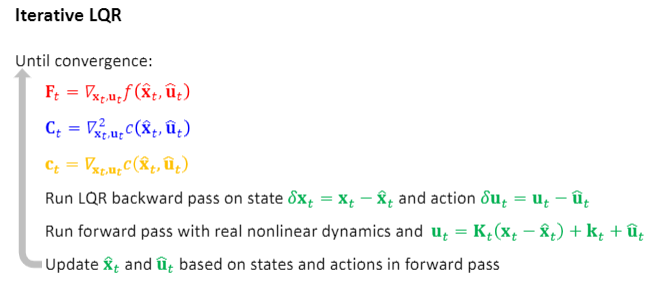

In [60]:
# initial setting
state_dim = 2
action_dim = 3
T = 20

x_hat = torch.rand(size=(state_dim, T))
u_hat = torch.rand(size=(action_dim, T))


def cost_function(x):
    return torch.sum(torch.pow(x, 2)) / 1000

dynamic_system = MLP(input_dim=5,
                     output_dim=2,
                     num_neurons=[],
                     hidden_act='ReLU')

# 

loss = torch.nn.MSELoss()

criteria = 1e-5

In [61]:
Fs, fs, Large_Cs, small_cs = linearization(x_hat, u_hat, dynamic_system, cost_function, state_dim, T)


Large_Q, small_q, Large_K, small_k, Large_V, small_v = backward_recursion_ilqr(state_dim, action_dim, Large_Cs, small_cs, Fs, fs, T)


xs, us = forward_recursion_ilqr(x_hat, u_hat, Large_K, small_k, dynamic_system, T)
us = torch.cat([us, torch.zeros(size=(action_dim, 1))], dim=1)

gap = loss(x_hat, xs) + loss(u_hat, us)

if gap is bigger than criteria, then repeat process with new xs, us

In [62]:
while gap > criteria:
#     print(x_hat)
#     print(u_hat)
    Fs, fs, Large_Cs, small_cs = linearization(x_hat, u_hat, dynamic_system, cost_func, state_dim, T)
    Large_Q, small_q, Large_K, small_k, Large_V, small_v = backward_recursion_ilqr(state_dim, action_dim, Large_Cs, small_cs, Fs, fs, T)
    xs, us = forward_recursion_ilqr(x_hat, u_hat, Large_K, small_k, dynamic_system, T)
    us = torch.cat([us, torch.zeros(size=(action_dim, 1))], dim=1)

    gap = loss(x_hat, xs) + loss(u_hat, us)
    
    x_hat = xs
    u_hat = us
    
print(xs)
print(us)

tensor([[0.2894,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan],
        [0.7576,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan]], grad_fn=<CatBackward>)
tensor([[inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.]],
       grad_fn=<CatBackward>)


In [63]:
dynamic_system(torch.ones(size=(1, 5)))
dynamic_system(torch.ones(size=(1, 5)))





tensor([[-0.0775, -0.1154]], grad_fn=<AddmmBackward>)